In [10]:
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use("seaborn-whitegrid")
from scipy.interpolate import interp1d
from scipy.stats import percentileofscore as inverse_percentile
from Utils.RK4 import RK4
from itertools import product 

In [38]:
# Examine the statistical properties of a saturation nonlinearity

U = cp.Uniform(-1, 1)
N = cp.Normal(0, 1)

S = N.sample(10000, 'L')

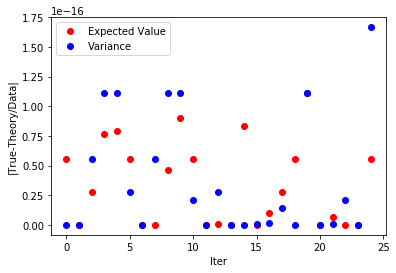

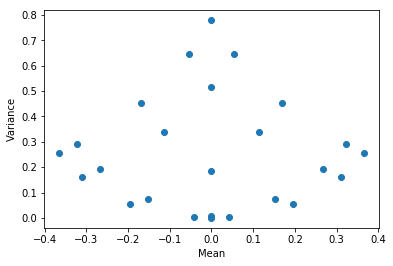

In [39]:
# The expected value is a function of the probability of exceeding the upper and lower bounds of the saturation function
def EVSat(X, L, U):
    PL = inverse_percentile(X, L)/100
    P = inverse_percentile(X, U)/100 - PL
    PU = 1 - P - PL
#     print(PL, P, PU)
    between = np.logical_and(X>=L, X<=U)
    E = np.mean(X[between])
    return PL*L + PU*U + P*E
    
def VarSat(X, L, U):
    PL = inverse_percentile(X, L)/100
    P = inverse_percentile(X, U)/100 - PL
    PU = 1 - P - PL
    between = np.logical_and(X>=L, X<=U)
    V = np.mean(X[between]**2) # not actually the variance
    E = EVSat(X, L, U)

    return PL*L**2 + PU*U**2 + P*V - E**2
    
data = []
for lb,ub in product([-1.5, -1, -0.5, -0.1, -0.01],[0.01, 0.1, 0.5, 1, 1.5]):
#     print(lb, ub)
    y = np.clip(S, lb, ub)
    E = np.mean(y)
    V = np.var(y)
    
    data.append([E, EVSat(S, lb, ub), V, VarSat(S, lb, ub)]) # True, and estimated 
    
E = np.array(data).T
plt.plot(np.abs(E[0]-E[1]), 'ro', label="Expected Value")
plt.plot(np.abs(E[2]-E[3]), 'bo', label="Variance")

plt.xlabel("Iter")
plt.ylabel("|True-Theory/Data|")
plt.legend()

plt.figure()
plt.plot(E[0], E[2], "o")
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.show()

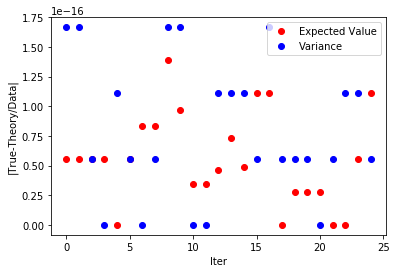

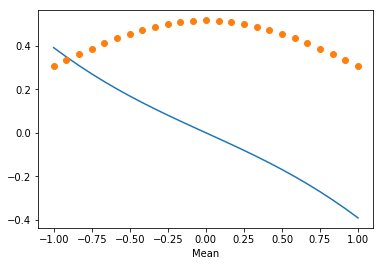

In [40]:
# In the previous section, the actual width of the saturation interval was changing. Here, the interval is fixed, but the mean is changing, which alters the distance to the bounds
data = []
lb = -1
ub = 1
means = np.linspace(-1, 1, 25)
for m in means:
    lb = -1 - m
    ub = 1 -m
    y = np.clip(S, lb, ub)
    E = np.mean(y)
    V = np.var(y)
    
    data.append([E, EVSat(S, lb, ub), V, VarSat(S, lb, ub)]) # True, and estimated 
    
E = np.array(data).T
plt.plot(np.abs(E[0]-E[1]), 'ro', label="Expected Value")
plt.plot(np.abs(E[2]-E[3]), 'bo', label="Variance")

plt.xlabel("Iter")
plt.ylabel("|True-Theory/Data|")
plt.legend()

plt.figure()
plt.plot(means, E[0], means, E[2], "o")
plt.xlabel("Mean")
# plt.ylabel("Variance")
plt.show()

In [70]:
# Examine how the state distribution varies with nominal/saturation 
# The true nonlinear system has control bounds [-1,1]
# Generate an arbitrary nominal control profile u(t)
# Then the bounds are UB-u(t) and LB-u(t)

def dyn(x, t, u0, lb, ub):
    k = 1
    u = np.clip(-k*x, lb-u0(t), ub-u0(t))
    a = 0.25
    return a*x + u 

ub = 1
lb = -1
tf = 15
x0 = cp.Normal(0, 1).sample(1000, 'L')

In [79]:
u = lambda t: np.sin(t/2)*0
t = np.linspace(0, tf, 100)
x = RK4(dyn, x0, t, args=(u, lb, ub))

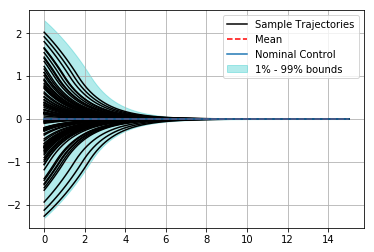

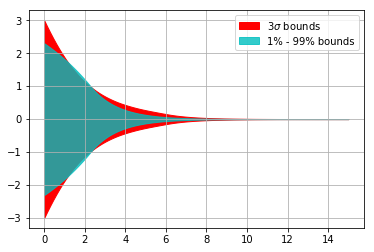

In [85]:
m = np.mean(x, axis=1)
s = np.std(x, axis=1)
plt.plot(t, x.T[0], 'k', label="Sample Trajectories")
plt.plot(t, x[:, ::10], 'k')

plt.plot(t, m, 'r--', label="Mean")
# plt.fill_between(t, m+3*s, m-3*s, alpha=0.3, color='c', label=r"$3\sigma$ bounds")
plt.fill_between(t, np.percentile(x, 99, axis=1), np.percentile(x, 1, axis=1), alpha=0.3, color='c', label=r"1% - 99% bounds")
plt.plot(t, u(t), label="Nominal Control")
plt.grid()
plt.legend()

plt.figure()
# plt.plot(t, x.T[0], 'k', label="Sample Trajectories")
# plt.plot(t, x[:, ::10], 'k')

# plt.plot(t, m, 'r--', label="Mean")
plt.fill_between(t, m+3*s, m-3*s, alpha=1, color='r', label=r"$3\sigma$ bounds")
plt.fill_between(t, np.percentile(x, 99, axis=1), np.percentile(x, 1, axis=1), alpha=0.8, color='c', label=r"1% - 99% bounds")
plt.grid()
plt.legend()

plt.show()

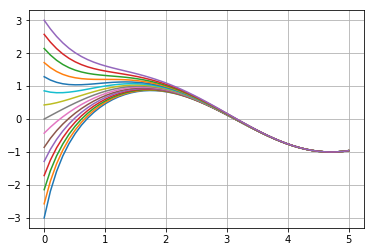

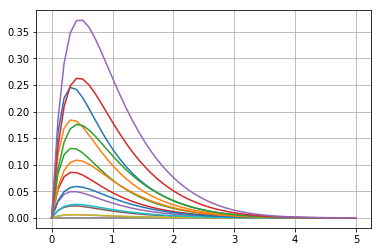

In [98]:
def dyn(x,t):
    ur = np.cos(t)-0.25*np.sin(t)**2
    xr = np.sin(t)
    e = x-xr
    u = -2*e
    return 0.25*x**2 + ur + u

def dyn_lin(x,t):
    return 0.5*np.sin(t)*x + -2*x

t = np.linspace(0, 5, 50)
x0 = np.linspace(-3,3, 15)
x = RK4(dyn, x0, t)
xl = RK4(dyn_lin, x0, t)

plt.figure()
plt.plot(t, x)
plt.grid()


plt.figure()
# plt.plot(t, x-np.sin(t)[:,None])
# plt.plot(t, xl, 'k--')
plt.plot(t, x-np.sin(t)[:,None] - xl)
plt.grid()

plt.show()